In [1]:
import pandas as pd
from torchvision.transforms import functional as F
from torchvision import transforms
import torch
from PIL import Image
import requests
from io import BytesIO
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

# Data Folder Info (File name and total rows)
 - Processing 100 images = 1 minute
 - Select which files to process based on data size. 

In [2]:
import pandas as pd
import os
folder_path = './data'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

rows_count = {}
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    rows_count[file] = len(df)

rows_count

{'Air Conditioners.csv': 720,
 'All Appliances.csv': 9576,
 'All Books.csv': 0,
 'All Car and Motorbike Products.csv': 1272,
 'All Electronics.csv': 9600,
 'All English.csv': 0,
 'All Exercise and Fitness.csv': 1176,
 'All Grocery and Gourmet Foods.csv': 960,
 'All Hindi.csv': 0,
 'All Home and Kitchen.csv': 1224,
 'All Movies and TV Shows.csv': 0,
 'All Music.csv': 0,
 'All Pet Supplies.csv': 648,
 'All Sports Fitness and Outdoors.csv': 1224,
 'All Video Games.csv': 0,
 'Amazon Fashion.csv': 2352,
 'Amazon Pharmacy.csv': 0,
 'Amazon-Products.csv': 551585,
 'Baby Bath Skin and Grooming.csv': 1392,
 'Baby Fashion.csv': 2208,
 'Baby Products.csv': 1056,
 'Backpacks.csv': 2064,
 'Badminton.csv': 1200,
 'Bags and Luggage.csv': 19152,
 'Ballerinas.csv': 1392,
 'Beauty and Grooming.csv': 1920,
 'Bedroom Linen.csv': 1224,
 'Blu-ray.csv': 0,
 'Camera Accessories.csv': 9600,
 'Cameras.csv': 9600,
 'Camping and Hiking.csv': 792,
 'Car Accessories.csv': 1392,
 'Car and Bike Care.csv': 960,
 'Car 

# Clean Data

In [3]:
product = 'WashingMachine'
file_list = ['Washing Machines'] # Furniture

df = pd.DataFrame()

for file in file_list:
    data = pd.read_csv(f"./data/{file}.csv")  # read each csv file
    if df.empty:
        df = data  # if full_df is empty, assign directly
    else:
        df = pd.concat([df, data], axis=0)  # concatenate dataframes horizontally


# Remove the currency symbol and commas, then convert to a numeric type
df['discount_price'] = pd.to_numeric(df['discount_price'].str.replace('₹', '').str.replace(',', ''), errors='coerce')
df['actual_price'] = pd.to_numeric(df['actual_price'].str.replace('₹', '').str.replace(',', ''), errors='coerce')
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

df['discount_price'] = df['discount_price'].fillna(df['actual_price'])

# columns_subset = ['image','discount_price','actual_price','ratings']
columns_subset = ['image','discount_price','actual_price','ratings']

df_cleaned = df.dropna(subset=['image','discount_price','actual_price','ratings'])


def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Condition for filtering out the outliers
    condition = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    return df.loc[condition]

df_cleaned = remove_outliers(df_cleaned, 'discount_price')
print("Cleaned dataframe dimension : ", df_cleaned.shape)

Cleaned dataframe dimension :  (540, 9)


# Extract Valid Image
If the link is valid, we store the image information along with prices and names, and do a bit of preprocessing with the image(normalize, pad and resize)

In [4]:
import torchvision.transforms as transforms
from PIL import Image

image_data = []
actual_price = []
discount_price = []
ratings = []
sub_category = []
name = []

class PadToSquare:
    def __init__(self, fill=(255, 255, 255), padding_mode='constant'):
        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        w, h = img.size
        max_wh = max(w, h)
        hp = int((max_wh - h) / 2)
        wp = int((max_wh - w) / 2)
        padding = (wp, hp, wp, hp)  # Left, Top, Right, Bottom
        return F.pad(img, padding, self.fill, self.padding_mode)


to_torch = transforms.Compose([
    PadToSquare(),
    transforms.ToTensor(),
    transforms.Resize((320,320)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for i in range(df_cleaned.shape[0]):
    response = requests.get(df_cleaned.iloc[i]['image'])
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image = image.convert('RGB') 
        image = to_torch(image)

        image_data.append(image)
        actual_price.append(df_cleaned.iloc[i]['actual_price'])
        discount_price.append(df_cleaned.iloc[i]['discount_price'])
        ratings.append(df_cleaned.iloc[i]['ratings'])
        sub_category.append(df_cleaned.iloc[i]['sub_category'])
        name.append(df_cleaned.iloc[i]['name'])
        
    if i%10 == 0:
        print(i)

# Concatenate torches to one batch
image_torch = torch.stack(image_data)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530


In [5]:
# Save data to pickle file

import pickle

combined_data = {
    "image_torch": image_torch,
    "actual_price": actual_price,
    "discount_price": discount_price,
    "ratings": ratings,
    "sub_category" : sub_category,
    "name" : name
}

# Serialize data to a binary file
with open(f'./output/{product}/input.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

In [4]:
import pickle

with open(f'./output/{product}/input.pkl', 'rb') as f:
    data = pickle.load(f)

image_torch = data['image_torch']
actual_price = data['actual_price']
discount_price = data['discount_price']
ratings = data['ratings']
sub_category = data['sub_category']
name = data['name']

# Train/Val/Test Split

In [5]:
# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # Optionally, use 1 - train_ratio - val_ratio

# Calculate sizes
total_images = image_torch.size(0)
train_size = int(total_images * train_ratio)
val_size = int(total_images * val_ratio)
test_size = total_images - train_size - val_size

# Shuffle indices
indices = torch.randperm(total_images)

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create subsets
train_image = image_torch[train_indices]
val_image = image_torch[val_indices]
test_image = image_torch[test_indices]

train_price = torch.tensor(discount_price)[train_indices]
val_price = torch.tensor(discount_price)[val_indices]
test_price = torch.tensor(discount_price)[test_indices]


# Initialize the StandardScaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on the training set only
scaler.fit(train_price.reshape(-1,1))  # Reshape y to a 2D array for compatibility with StandardScaler

# Transform the train, validation, and test sets
train_price = torch.tensor(scaler.transform(train_price.reshape(-1,1)).flatten())  # Reshape to flatten back to 1D array
val_price = torch.tensor(scaler.transform(val_price.reshape(-1,1)).flatten())
test_price = torch.tensor(scaler.transform(test_price.reshape(-1,1)).flatten())

# Augment Images

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomTensorDataset(Dataset):
    """ Dataset wrapping tensors.
    
    Each sample will be retrieved by indexing tensors along the first dimension.
    
    Arguments:
        data_tensor (Tensor): contains sample data.
        target_tensor (Tensor): contains sample targets (labels).
        transform (callable, optional): optional transform to be applied on a sample.
    """

    def __init__(self, data_tensor, target_tensor, transform=None):
        assert data_tensor.size(0) == target_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.transform = transform

    def __getitem__(self, index):
        x = self.data_tensor[index]

        if self.transform:
            x = self.transform(x)  # Apply transformation

        y = self.target_tensor[index]
        return x, y

    def __len__(self):
        return self.data_tensor.size(0)

# Assuming image_torch is a 4D tensor [N, C, H, W]
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomResizedCrop(224, scale=(0.5, 0.9), ratio=(1.0, 1.0)),
    transforms.Resize((320,320)),
])

# Create Dataloader

**When splitting the dataset, We transform the images so that it is trained on augmented images but it validates and tests on original images. We could print out a few images like below**

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = CustomTensorDataset(train_image, train_price, transform=transform)
# train_dataset = TensorDataset(train_image, train_price)
val_dataset = TensorDataset(val_image,val_price)
test_dataset =  TensorDataset(test_image,test_price)

batch_size = 32

# total_samples = len(tensor_dataset)
# train_size = int(0.7 * total_samples)
# val_size = int(0.15 * total_samples)
# test_size = total_samples - train_size - val_size

# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(tensor_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Check Image Quality/Augmentation

## Original Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


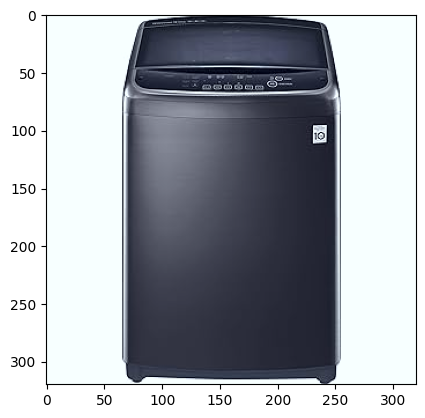

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


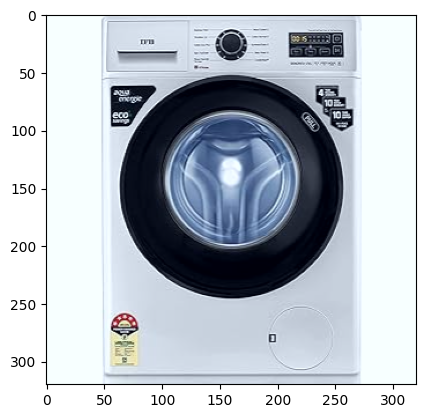

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


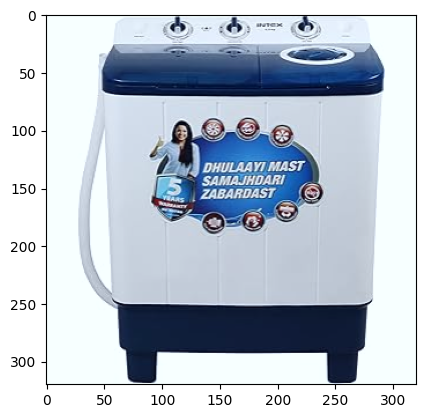

In [8]:
for x,y in val_loader:
    x = x
    y = y
    break

import matplotlib.pyplot as plt
for i in range(3):
    plt.imshow((x[i]*0.229+0.456).permute(1,2,0))
    plt.show()

## Augmented Images

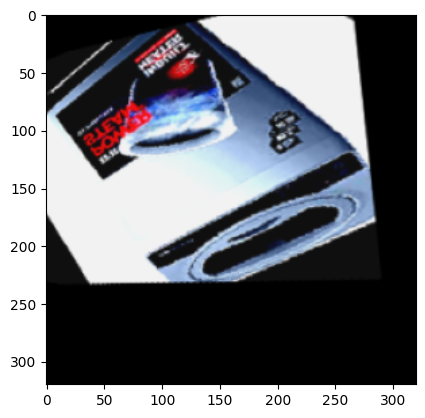

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


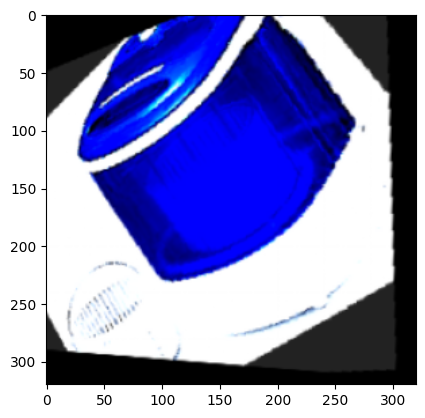

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


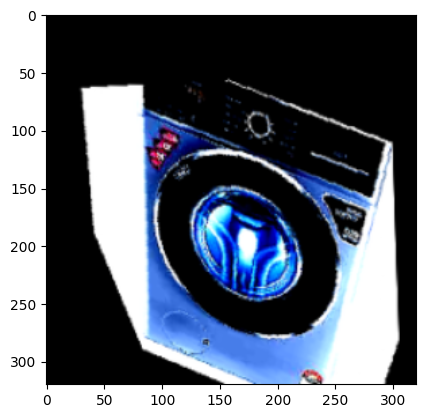

In [9]:
for x,y in train_loader:
    x = x
    y = y
    break

import matplotlib.pyplot as plt
for i in range(3):
    plt.imshow(x[i].permute(1,2,0))
    plt.show()

# Define Model

In [10]:
class paper(nn.Module):
    def __init__(self):
        super(paper, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)
        )


    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

# Train Model

In [11]:
# Early Stopping test
def train_loop(dataloader,val_loader, model, criterion, optimizer, L1 = 0):

    train_loss, correct = 0, 0
    val_loss, val_correct = 0, 0

    for i, batch in enumerate(dataloader):
        model.train() # not required for this example but good to know

        # Number of training records
        size = len(dataloader.dataset)
        num_batches = len(dataloader)

        # Compute prediction and loss
        X, y = batch

        # X = X.to(device)
        # y = y.to(device)

        y = y.float()
        y = y.reshape(-1,1)
        
        y_pred = model.forward(X)
        y_pred = y_pred.float()
        loss = criterion(y_pred, y) + L1*sum([p.abs().sum() for p in model.parameters()])
        # correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        loss.backward()

        train_loss += loss.item()

        # Gradient step and zero gradients
        optimizer.step()
        optimizer.zero_grad()



    with torch.no_grad():
        for X, y in val_loader:
            
            # X = X.to(device)
            # y = y.to(device)            

            size_val = len(val_loader.dataset)
            num_batches_val = len(val_loader)


            y = y.float()
            y = y.reshape(-1,1)

            y_pred = model(X)
            val_loss += (criterion(y_pred, y)).item()

    avg_loss = train_loss/num_batches
    # avg_acc = correct/size

    avg_loss_val = val_loss / num_batches_val
    # avg_acc_val = val_correct / size_val

    return avg_loss, avg_loss_val 
            
def test_loop(dataloader, model, criterion):

    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            y = y.float()
            y = y.reshape(-1,1)
            y_pred = model(X)
            test_loss += (criterion(y_pred, y)).item()


    avg_loss = test_loss/num_batches

    return avg_loss
    



In [13]:
import numpy as np

LR = 0.0005
EPOCH = 30
L2 = 0.001
L1 = 0

model = paper()
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss(beta = 0.7)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=L2)
# scheduler = ExponentialLR(optimizer, gamma=0.9)

best_val_loss = float('inf')
patience = 10  # Set the patience for early stopping

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss = []
test_acc = []

for e in range(EPOCH):
    
    epoch_train_loss, epoch_val_loss = train_loop(train_loader, val_loader, model, criterion, optimizer,L1 = L1)
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    epoch_test_loss =  test_loop(test_loader, model, criterion)
    test_loss.append(epoch_test_loss)
    print('Epoch {}'.format(e+1), "Epoch Validation Loss",epoch_val_loss, "Epoch Train Loss",epoch_train_loss)
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        consecutive_no_improvement = 0
    else:
        consecutive_no_improvement += 1

    if consecutive_no_improvement >= patience:
        print(f'Early stopping at epoch {e+1} due to no improvement in validation loss.')
        break

Epoch 1 Epoch Validation Loss 0.4095888137817383 Epoch Train Loss 0.5376558393239975
Epoch 2 Epoch Validation Loss 0.37714672088623047 Epoch Train Loss 0.472511014342308
Epoch 3 Epoch Validation Loss 0.41165515780448914 Epoch Train Loss 0.4585739731788635
Epoch 4 Epoch Validation Loss 0.3573648929595947 Epoch Train Loss 0.4235681056976318
Epoch 5 Epoch Validation Loss 0.4110334515571594 Epoch Train Loss 0.4423434376716614
Epoch 6 Epoch Validation Loss 0.4472152888774872 Epoch Train Loss 0.43715918958187105
Epoch 7 Epoch Validation Loss 0.4025656282901764 Epoch Train Loss 0.4225699633359909
Epoch 8 Epoch Validation Loss 0.4868296682834625 Epoch Train Loss 0.3833421111106873
Epoch 9 Epoch Validation Loss 0.3244439959526062 Epoch Train Loss 0.4087263882160187
Epoch 10 Epoch Validation Loss 0.3710072338581085 Epoch Train Loss 0.3391450747847557
Epoch 11 Epoch Validation Loss 0.3414978086948395 Epoch Train Loss 0.3680210798978806
Epoch 12 Epoch Validation Loss 0.3907017707824707 Epoch Train

## Save parameters of model for later use

In [14]:
# Save parameters of model for later use
# torch.save(model.state_dict(), f'./output/{product}/model_state_dict.pth')

In [15]:
# Save Results for future use
import pickle

combined_data = {
    "train_loss": train_loss,
    "test_loss": test_loss,
    "val_loss": val_loss,
}

# Serialize data to a binary file
with open(f'./output/{product}/loss_paper.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

In [16]:
# Call in past results
import pickle

with open(f'./output/{product}/loss_paper.pkl', 'rb') as f:
    data = pickle.load(f)

train_loss = data['train_loss']
test_loss = data['test_loss']
val_loss = data['val_loss']

# Results

## Loss per Epoch

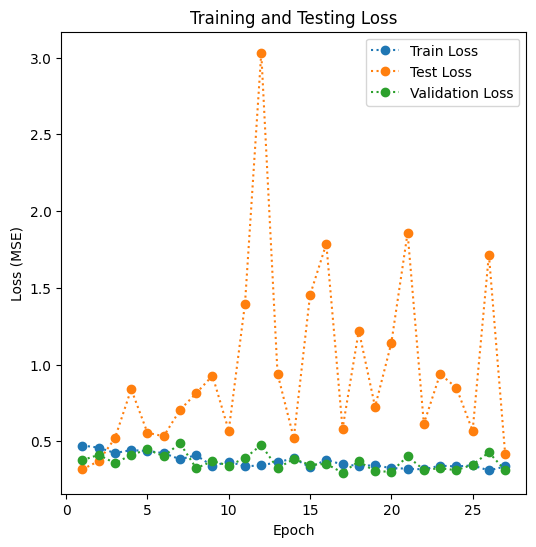

In [17]:
import matplotlib.pyplot as plt
from IPython import display


fig = plt.figure(1, figsize=(6, 6))
plt.clf()

ax1 = fig.add_subplot(1, 1, 1) # (Rows, Columns, Position)
epochs = [int(i+1) for i in range(len(train_loss[1:]))]

ax1.set_title('Training and Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.plot(epochs, train_loss[1:], label='Train Loss', marker='o', linestyle=':')
ax1.plot(epochs, test_loss[1:], label='Test Loss', marker='o', linestyle=':')
ax1.plot(epochs, val_loss[1:], label='Validation Loss', marker='o', linestyle=':')
ax1.legend()
# plt.savefig(f'./images/{product}_epoch_MSE.png', transparent=True, dpi=300)
display.display(plt.gcf())
display.clear_output(wait=True)

## Training Price Distribution

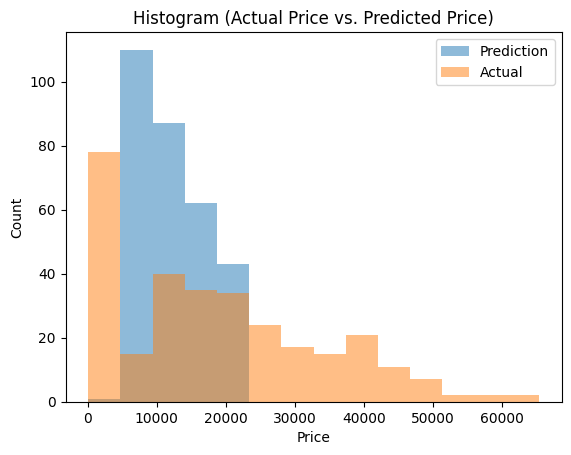

In [18]:
pred = []
actual = []

with torch.no_grad():
    for X, y in train_loader:
        
        y = y.float()
        y = y.numpy()

        
        y_pred = model(X)
        y_pred = y_pred.flatten().detach().numpy()

        pred.extend(y_pred)
        actual.extend(y)

pred = scaler.inverse_transform(np.array(pred).reshape(-1,1)).flatten()
actual = scaler.inverse_transform(np.array(actual).reshape(-1,1)).flatten()

# Determine the common range for the histograms
bin_min = min(min(pred), min(actual))  # Lowest value between both
bin_max = max(max(pred), max(actual))  # Highest value between both

# Define the number of bins or the bin width you desire
number_of_bins = 15  # For example, 30 bins
# Or

# If using number of bins directly:
bins = np.linspace(bin_min, bin_max, number_of_bins)

# Plot histograms
plt.hist(pred, bins=bins, alpha=0.5, label='Prediction')
plt.hist(actual, bins=bins, alpha=0.5, label='Actual')
plt.title("Histogram (Actual Price vs. Predicted Price)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend()

# Save the figure
# plt.savefig(f'./images/{product}_Histogram_train_HU.png', transparent=True, dpi=300)
plt.show()


## Validatoin Price Distribution

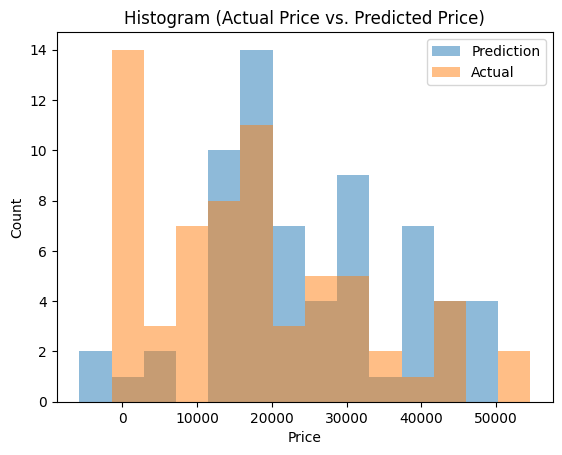

In [19]:
pred = []
actual = []

with torch.no_grad():
    for X, y in val_loader:
        
        y = y.float()
        y = y.numpy()

        
        y_pred = model(X)
        y_pred = y_pred.flatten().detach().numpy()

        pred.extend(y_pred)
        actual.extend(y)

pred = scaler.inverse_transform(np.array(pred).reshape(-1,1)).flatten()
actual = scaler.inverse_transform(np.array(actual).reshape(-1,1)).flatten()
# Determine the common range for the histograms
bin_min = min(min(pred), min(actual))  # Lowest value between both
bin_max = max(max(pred), max(actual))  # Highest value between both

# Define the number of bins or the bin width you desire
number_of_bins = 15  # For example, 30 bins
# Or

# If using number of bins directly:
bins = np.linspace(bin_min, bin_max, number_of_bins)

# Plot histograms
plt.hist(pred, bins=bins, alpha=0.5, label='Prediction')
plt.hist(actual, bins=bins, alpha=0.5, label='Actual')
plt.title("Histogram (Actual Price vs. Predicted Price)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend()
# plt.savefig(f'./images/{product}_Histogram_val_HU.png', transparent=True, dpi=300)
plt.show()

## Confusion matrix
Although our problem is a regression problem, we tried splitting the outputs and the original prices into High and Low prices based on the median to check whether the model could accurately predict "High Priced" products and "Low Priced" products.

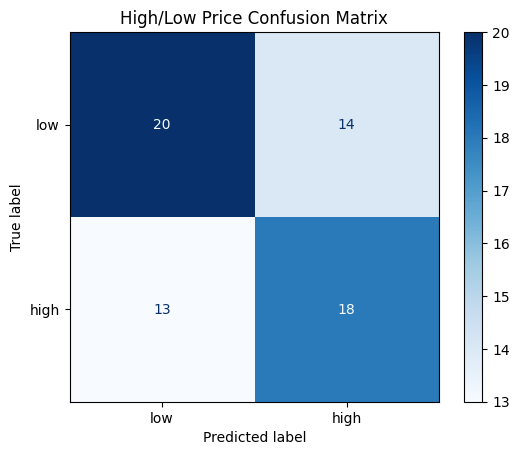

Accuracy :  0.5846153846153846


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

pred_median = np.median(pred)
actual_median = np.median(actual)

pred_cat = ['high' if x > pred_median else 'low' for x in pred]
actual_cat = ['high' if x > actual_median else 'low' for x in actual]

# Calculate confusion matrix
cm = confusion_matrix(actual_cat, pred_cat, labels=['low', 'high'])

# Plotting using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low', 'high'])

disp.plot(cmap=plt.cm.Blues)
plt.title('High/Low Price Confusion Matrix')
plt.savefig(f'./images/{product}_Heatmap_Huber.png', transparent=True, dpi=300)
plt.show()

accuracy = accuracy_score(actual_cat, pred_cat)
print("Accuracy : ",accuracy)

# Model Analysis
**What areas of the image does the machine focus on?**

## Saliency Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


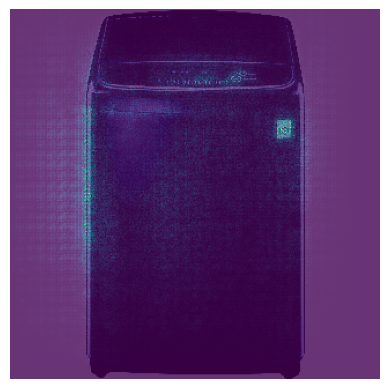

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


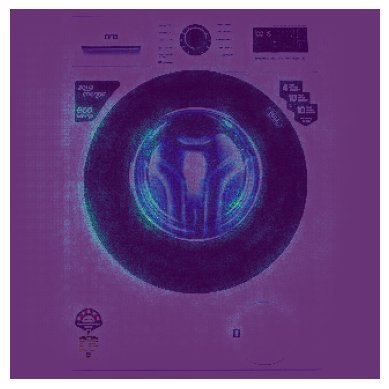

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


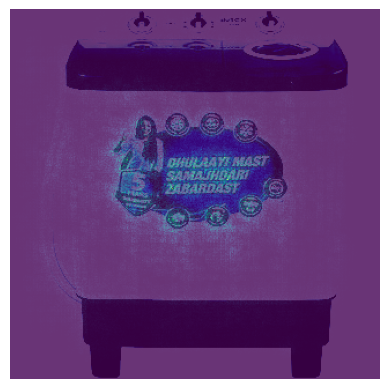

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


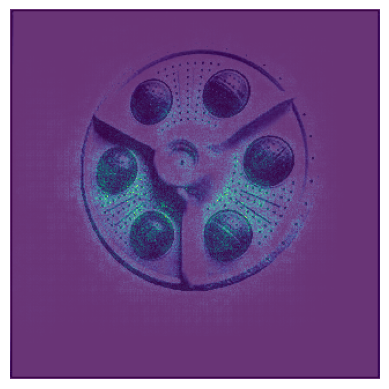

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


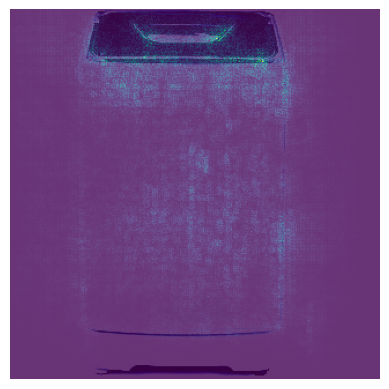

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


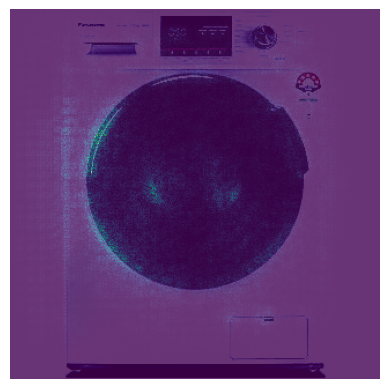

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


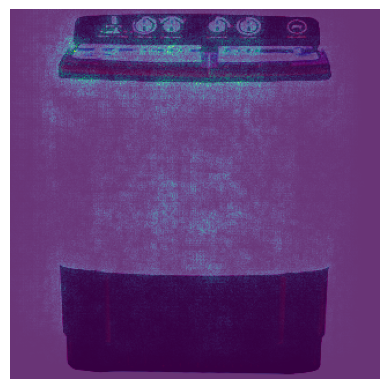

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


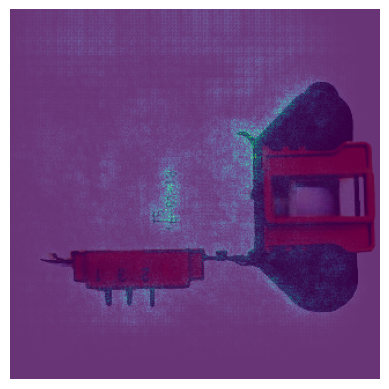

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


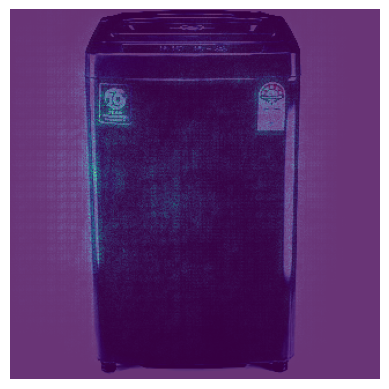

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


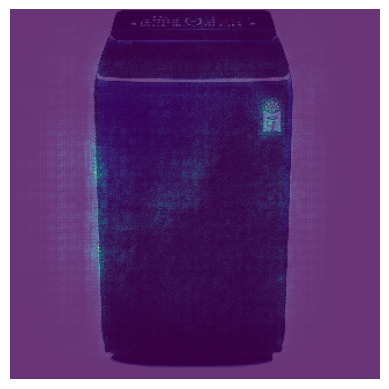

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


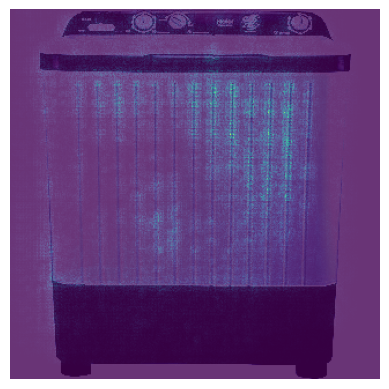

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


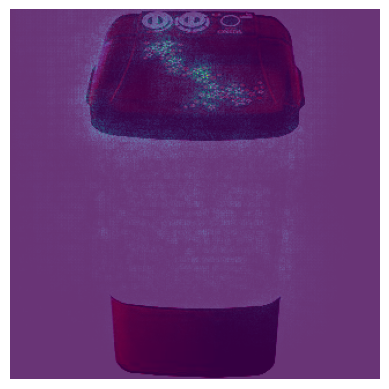

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


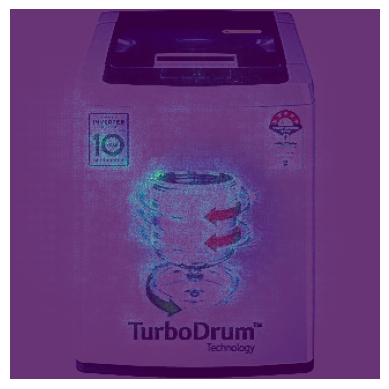

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


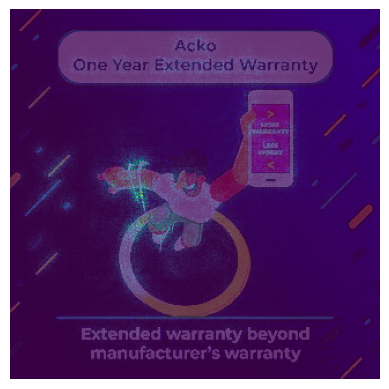

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


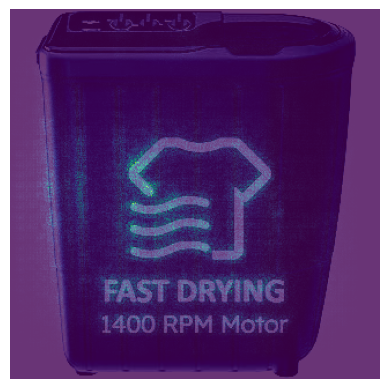

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


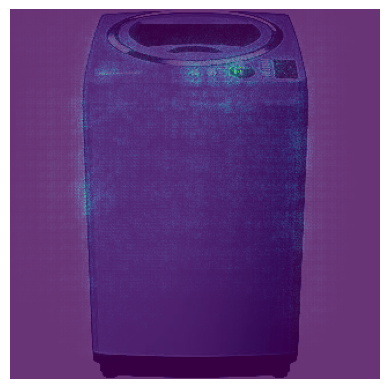

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


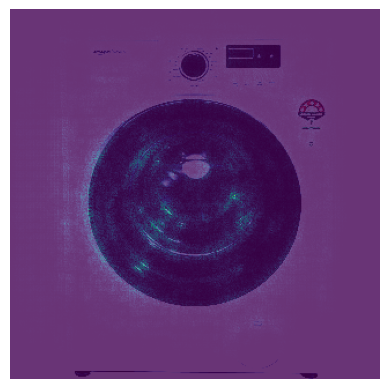

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


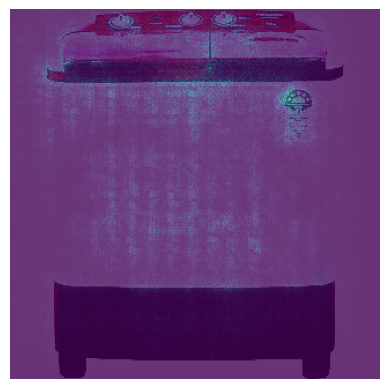

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


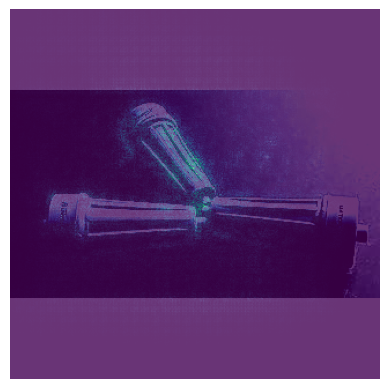

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


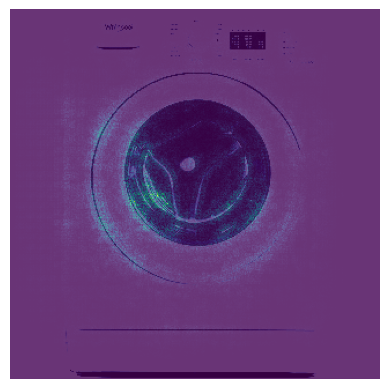

In [21]:
import torch
from torchvision import models, transforms
from PIL import Image

model.eval()

for x,y in val_loader:
    x_train = x
    y_train = y
    break

for i in range(20):
    x = x_train[i].unsqueeze(0)  # Add batch dimension

    x.requires_grad_()
    outputs = model(x)

    # Assume the model has a single output node
    # If the model output is more complex, adapt the indexing
    output = outputs[0]

    model.zero_grad()
    output.backward()

    saliency, _ = torch.max(x.grad.data.abs(), dim=1)  # Take the max across color channels

    plt.imshow(x.squeeze(0).permute(1,2,0).detach().numpy())
    plt.imshow(saliency[0], alpha = 0.8)
    plt.axis('off')
    plt.show()

# Class Activaiton Map Analysis

c:\Users\JaeHoBahng\anaconda3\envs\NNPROJ\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


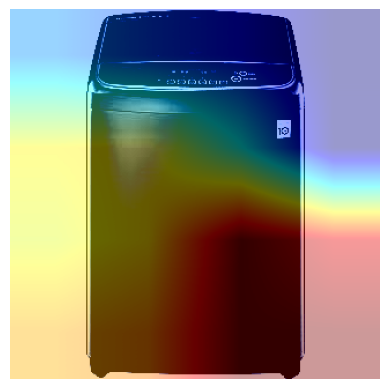

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


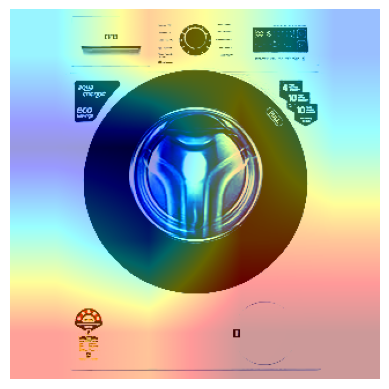

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


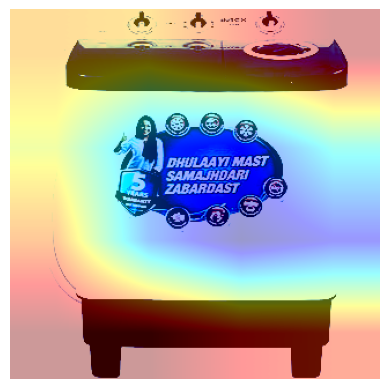

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


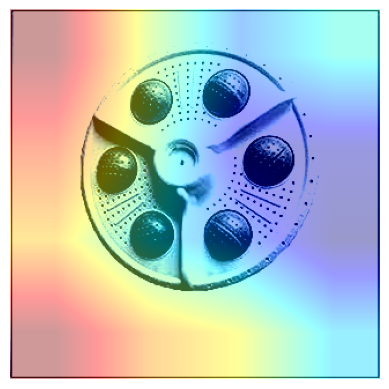

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


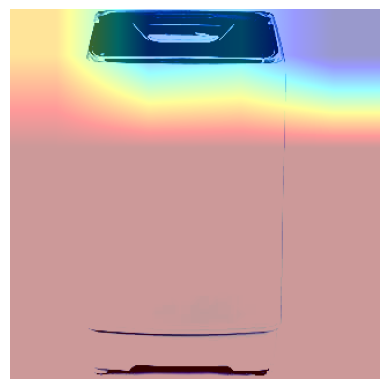

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


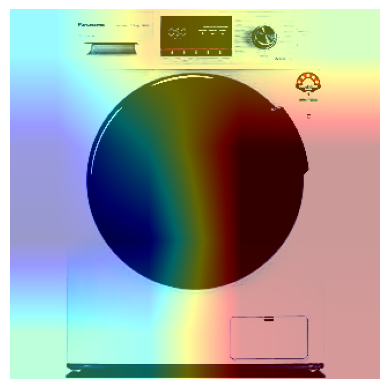

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


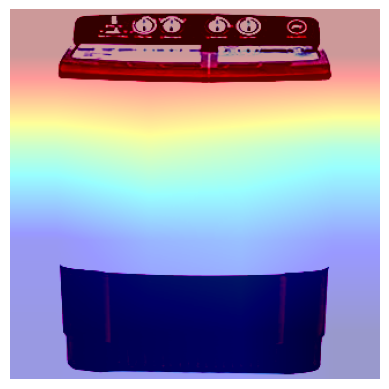

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


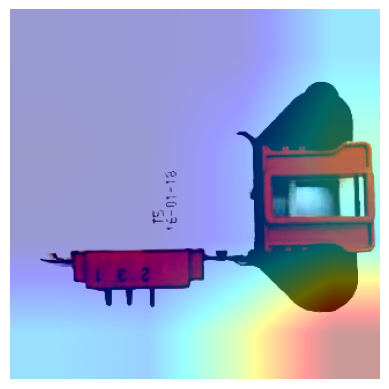

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


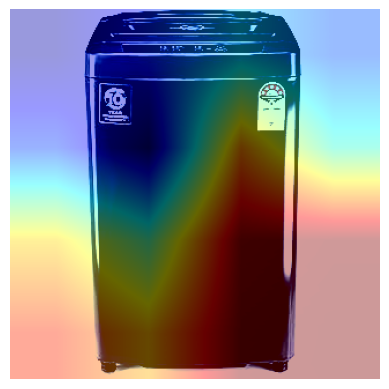

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


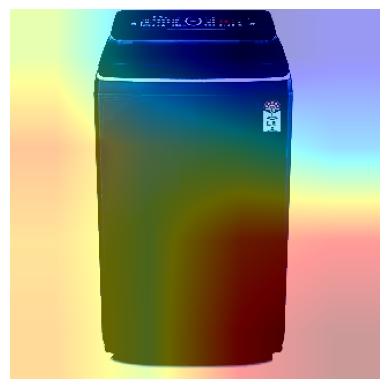

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


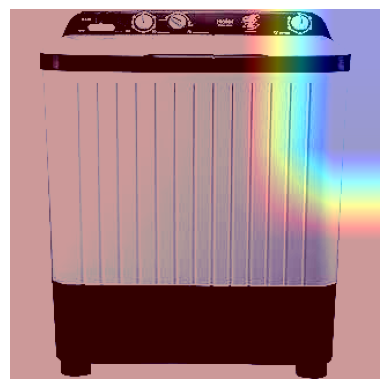

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


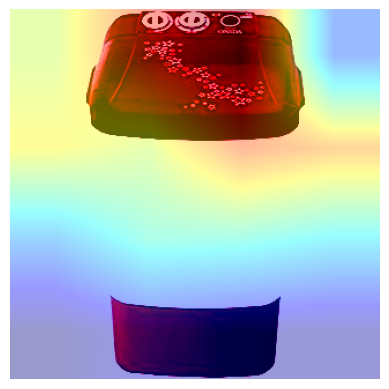

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


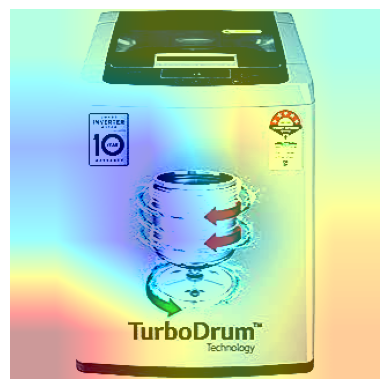

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


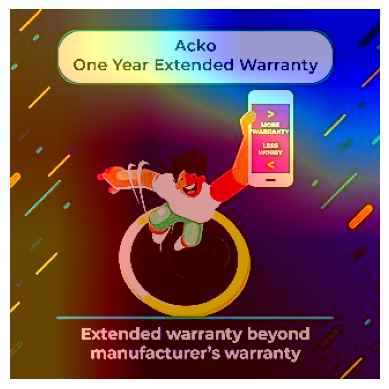

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


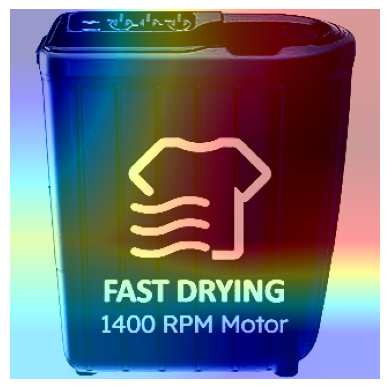

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


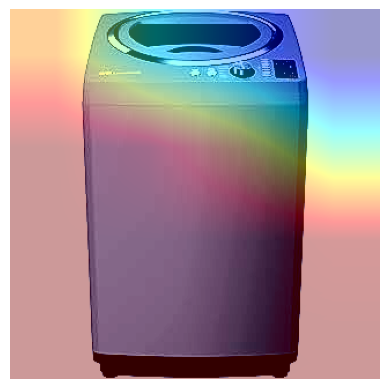

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


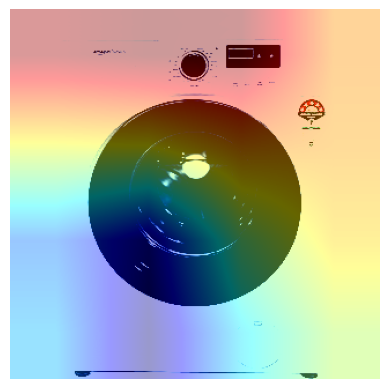

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


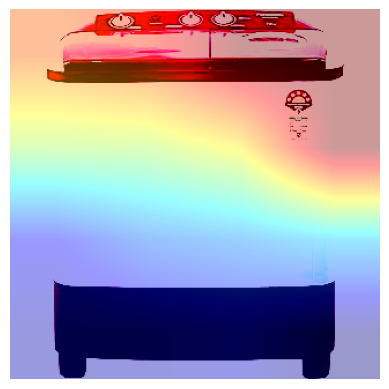

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


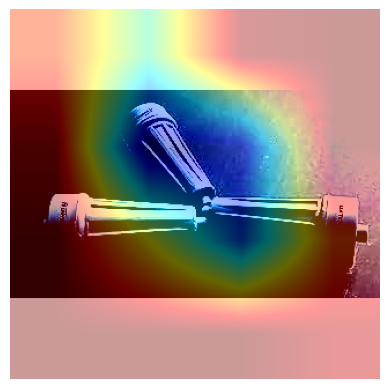

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


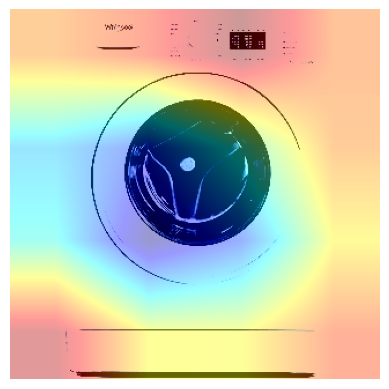

In [22]:
import torch
import torch.nn as nn

class PaperCAM(nn.Module):
    def __init__(self, original_model):
        super(PaperCAM, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[0][:-1])  # Assuming 'conv_layer' ends with a ReLU or pooling
        self.last_conv = list(original_model.children())[0][-1]  # The last conv layer
        self.classifier = nn.Sequential(*list(original_model.children())[1])

    def forward(self, x):
        x = self.features(x)
        x = self.last_conv(x)
        self.feature_maps = x  # Save the feature maps after the last conv layer
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


cam_model = PaperCAM(model)
cam_model.eval()

# Register hook to capture gradients
gradient = None  # Define a variable to hold your gradients globally

def save_gradient(module, grad_input, grad_output):
    global gradient
    gradient = grad_output[0]  # You want the output gradient

cam_model.last_conv.register_backward_hook(save_gradient)


for x,y in val_loader:
    x_train = x
    y_train = y
    break


for i in range(20):
    x = x_train[i].unsqueeze(0)  # Add batch dimension
    x.requires_grad_(True)

    # Forward pass
    output = cam_model(x)

    # Create a fake label to compute loss if you have a single output node (binary classification)
    label = y # Example label
    loss_fn = nn.SmoothL1Loss()
    loss = loss_fn(output.squeeze(), label)  # Compute loss

    # Backward pass
    loss.backward()

    # Use the stored gradients and feature maps
    gradients = gradient[0]  # Gradient captured by the hook
    pooled_gradients = torch.mean(gradients, dim=[1, 2])

    # Weight the channels of the feature maps by the corresponding gradients
    for i in range(gradients.shape[0]):  # iterate over the channels
        cam_model.feature_maps.data[:, i, :, :] *= pooled_gradients[i]

    # Generate the CAM by averaging the channels of the feature maps
    cam = torch.mean(cam_model.feature_maps, dim=1)[0].cpu().detach().numpy()
    cam = np.maximum(cam, 0)  # Apply ReLU to only get positive influences
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam_img = np.uint8(255 * cam)  # Scale to byte range for visualization

    # Resize and display
    import cv2
    cam_img = cv2.resize(cam_img, (x.shape[2], x.shape[3]))
    heatmap = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.5 + np.array(x.squeeze(0).permute(1,2,0).detach().numpy()) * 0.5

    # import matplotlib.pyplot as plt
    # plt.imshow(superimposed_img/255)
    # plt.axis('off')
    # plt.show()

    plt.imshow(x.squeeze(0).permute(1,2,0).detach().numpy())
    plt.imshow(heatmap, alpha = 0.4)
    plt.axis('off')
    plt.show()